In [1]:
###

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# load data
df = pd.read_csv('in-vehicle-coupon-recommendation.csv')

(12684, 26),
 destination                 0
passanger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12576
Bar                       107
CoffeeHouse               217
CarryAway                 151
RestaurantLessThan20      130
Restaurant20To50          189
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64


<AxesSubplot:>

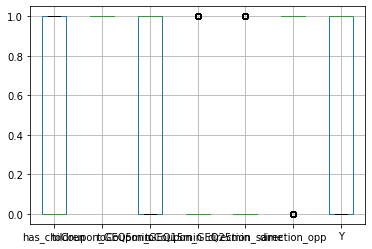

In [26]:
print(f"{df.shape},\n {df.isnull().sum()}")

# create df withou temperature
df2 = df.drop(['temperature'], axis=1)

# check boxplots
df2.boxplot()


# check distribution
#df.hist()


